## GR5241 Statistical Machine Learning
### Data Analysis Project Milestone 1
### Name: Kangshuo Li  UNI: kl3259
![](GR5241_PROJ1_BG.png)

![](GR5241_PROJ1_2.png)

#### Setup

In [2]:
import torch
import torchvision
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import time
import os
import re
os.getcwd()

'/Users/kangshuoli/Documents/VScode_workspace/GR5241/Proj_milestone_1'

#### Data processing

In [3]:
# Data download and preprocessing
from torch.utils import data

DOWNLOAD_MNIST = False # If already download , set as False

train_data = torchvision.datasets.MNIST(
    root ="./mnist/",
    train = True , # this is training data
    # transform = torchvision.transforms.ToTensor(),
    download = DOWNLOAD_MNIST
)
test_data = torchvision.datasets.MNIST(root = "./mnist/", train = False)

# change the features to numpy
X_train = train_data.train_data.numpy()
X_test = test_data.test_data.numpy()

# change the labels to numpy
Y_train = train_data.train_labels.numpy()

Y_test = test_data.test_labels.numpy()

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 ![](GR5241_PROJ_1_Q1.png)

##### (a)

(60000, 28, 28)
(60000,)


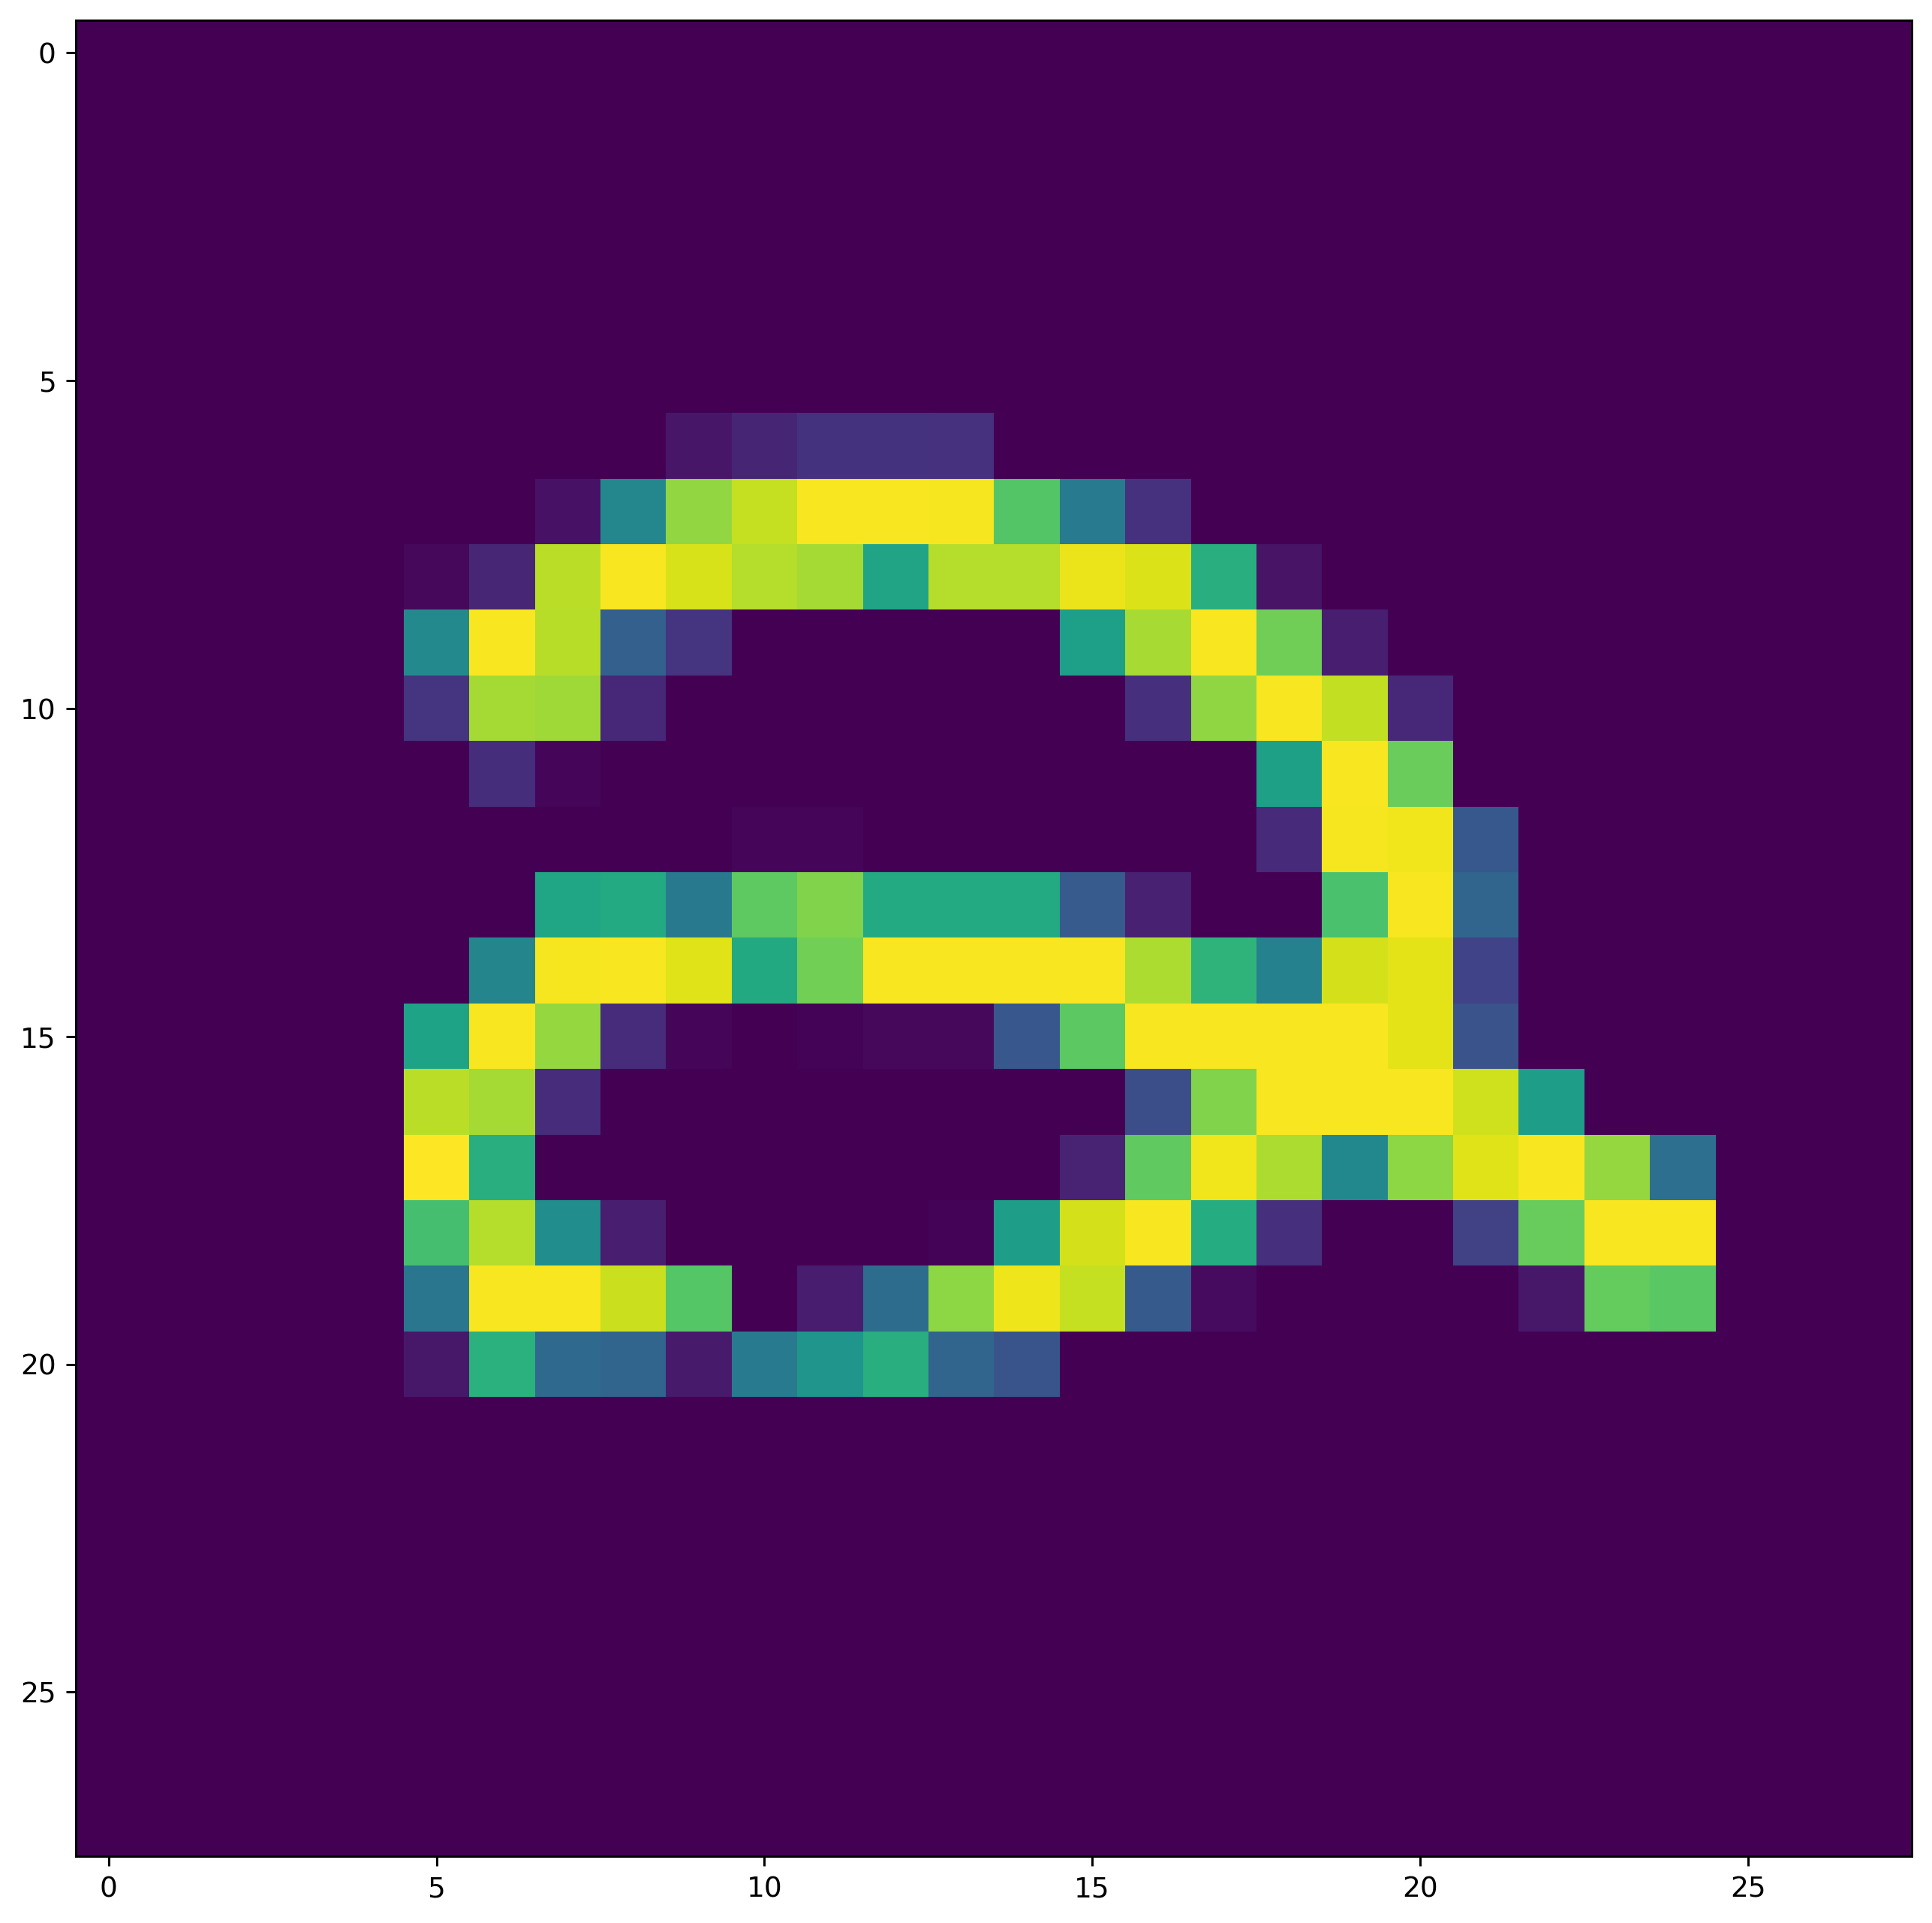

The corresponding label is: 2


In [3]:
print(X_train.shape) #(60000, 28, 28)
print(Y_train.shape) # (60000,)

random_index = np.random.randint(0, X_train.shape[0] - 1)
sample = X_train[random_index,:,:]
fig, ax = plt.subplots(1, 1, figsize = (12,12), dpi = 270)
ax.imshow(sample)
plt.show()
print(f'The corresponding label is: {Y_train[random_index]}')

According to the image and the label we sampled, the number shown from the image matches the label from Y_train.

##### (b)

In [4]:
print(f'The dimension of X_train: {X_train.shape}')
print(f'The dimension of X_test: {X_test.shape}')

# print(np.max(X_train)) # 255
# print(np.min(X_train)) # 0
# print(np.max(X_test)) # 255
# print(np.min(X_test)) # 0
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))
assert np.max(X_train) == 1
assert np.min(X_train) == 0
assert np.max(X_test) == 1
assert np.min(X_test) == 0

The dimension of X_train: (60000, 28, 28)
The dimension of X_test: (10000, 28, 28)


The dimension of X_train is 60000 * 28 * 28, and the dimension of X_test is 10000 * 28 * 28. 

##### (c)

In [15]:
# Convert them into dataframe
Y_train_df = pd.DataFrame(Y_train).astype(object)
Y_test_df = pd.DataFrame(Y_test).astype(object)

# Use the get_dummies() method in pandas
Y_train_df = pd.get_dummies(Y_train_df)
Y_train_onehot = Y_train_df.values
print(f'Y_train before onehot encoding: \n {Y_train}')
print(f'After onehot encoding, the shape of Y_train is: {Y_train_df.values.shape}')
print(Y_train_df.head())
Y_test_df = pd.get_dummies(Y_test_df)
Y_test_onehot = Y_test_df.values
print(f'Y_test before onehot encoding: \n {Y_test}')
print(f'After onehot encoding, the shape of Y_test is: {Y_test_df.values.shape}')
print(Y_test_df.head())

Y_train before onehot encoding: 
 [5 0 4 ... 5 6 8]
After onehot encoding, the shape of Y_train is: (60000, 10)
   0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9
0    0    0    0    0    0    1    0    0    0    0
1    1    0    0    0    0    0    0    0    0    0
2    0    0    0    0    1    0    0    0    0    0
3    0    1    0    0    0    0    0    0    0    0
4    0    0    0    0    0    0    0    0    0    1
Y_test before onehot encoding: 
 [7 2 1 ... 4 5 6]
After onehot encoding, the shape of Y_test is: (10000, 10)
   0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9
0    0    0    0    0    0    0    0    1    0    0
1    0    0    1    0    0    0    0    0    0    0
2    0    1    0    0    0    0    0    0    0    0
3    1    0    0    0    0    0    0    0    0    0
4    0    0    0    0    1    0    0    0    0    0


The label in this question is 0-9, which is the meaning of the image. While integer encoding may have the natrual order like 1 + 2 = 3, one-hot encoding can aviod this unexpected order of value, which is beneficial for the classification. Besides that, one-hot encoding can enlarge the label dimension with dummy variables, this can provide same distances among each classes(e.g. (0,0,1), (0,1,0), (1,0,0) are 3 classes with same distance $\sqrt{2}$ with each other) that eliminate the ordinal effect. 

![](GR5241_PROJ1_Q2.png)

##### (a)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# flatten the image
X_train_list = []
for i in np.arange(X_train.shape[0]):
    X_train_list.append(X_train[i,:,:].flatten(order = 'C'))
X_test_list = []
for i in np.arange(X_test.shape[0]):
    X_test_list.append(X_test[i,:,:].flatten(order = 'C'))
X_train_flattened = np.stack(X_train_list)
X_test_flattened = np.stack(X_test_list)

In [17]:
params_knn = {
    'n_neighbors': [2, 5, 10], 
    'weights': ["uniform", "distance"], 
    'p': [2], 
    'n_jobs': [-1]
}

gs_knn = GridSearchCV(
    estimator = KNeighborsClassifier(), 
    param_grid = params_knn, 
    cv = 5, 
    scoring = 'accuracy', 
    refit = True, 
    n_jobs = -1, 
    verbose = 0
)
gs_knn.fit(X = X_train_flattened, y = Y_train_onehot)
print(f'The best training score of KNN is: {gs_knn.best_score_:0.4f}, the parameters used are: {gs_knn.best_params_}')
print(f'The prediction score of KNN is: {accuracy_score(Y_test_onehot, gs_knn.best_estimator_.predict(X_test_flattened)):0.4f}')

The best training score of KNN is: 0.9694, the parameters used are: {'n_jobs': -1, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
The prediction score of KNN is: 0.9691


> C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. These accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule’s precondition if the accuracy of the rule improves without it.

> CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.

> scikit-learn uses an optimised version of the CART algorithm. 

If we use CART as an approximation of C4.5 by using sklearn, then the code is: 

In [19]:
# already gridsearched, use the best parameter to reduce the training time cost
# params_ada = {
#     'base_estimator': [DecisionTreeClassifier(max_depth = 8), DecisionTreeClassifier(max_depth = 6)],
#     'n_estimators': [100, 200, 500, 1000], 
#     'learning_rate': [0.01, 0.1, 0.2], 
#     'algorithm': ['SAMME.R'], 
#     'random_state': [42]
# }

params_ada = {
    'base_estimator': [DecisionTreeClassifier(max_depth = 8)],
    'n_estimators': [1000], 
    'learning_rate': [0.2], 
    'algorithm': ['SAMME.R'], 
    'random_state': [42]
}

gs_ada = GridSearchCV(
    estimator = AdaBoostClassifier(), 
    param_grid = params_ada, 
    cv = 5, 
    scoring = 'accuracy', 
    refit = True, 
    n_jobs = -1, 
    verbose = 1
)


gs_ada.fit(X = X_train_flattened, y = Y_train)
print(f'The best training score of AdaBoost is: {gs_ada.best_score_:0.4f}, the parameters used are: {gs_ada.best_params_}')
print(f'The prediction score of AdaBoost is: {accuracy_score(Y_test, gs_ada.best_estimator_.predict(X_test_flattened)):0.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The best training score of AdaBoost is: 0.9563, the parameters used are: {'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(max_depth=8), 'learning_rate': 0.2, 'n_estimators': 1000, 'random_state': 42}
The prediction score of AdaBoost is: 0.9600


In [6]:
X_train_flattened_df = pd.DataFrame(data = X_train_flattened)
sample_index = X_train_flattened_df.sample(
    n = 6000, 
    replace = False, 
    random_state = 42
).index
X_train_subsampled = X_train_flattened_df.iloc[sample_index,:]
Y_train_subsampled = Y_train[sample_index]
assert X_train_subsampled.shape[0] == Y_train_subsampled.shape[0]
X_train_subsampled.index = np.arange(X_train_subsampled.shape[0])

In [5]:
# params_svc = {
#     'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], 
#     'kernel': ['rbf'], 
#     'degree': [3, 4, 5, 6], 
#     'gamma': ['scale', 'auto'], 
#     'shrinking': [True], 
#     'tol': [0.0001, 0.00001], 
#     'verbose': [False], 
#     'random_state': [42]
# }
# gs_svc = GridSearchCV(
#     estimator = SVC(), 
#     param_grid = params_svc, 
#     cv = 5, 
#     scoring = 'accuracy', 
#     refit = True, 
#     n_jobs = -1, 
#     verbose = 2
# )
# gs_svc.fit(X = X_train_subsampled, y = Y_train_subsampled)
# print(f'The best training score of SVM classifier is: {gs_svc.best_score_:0.4f}, the parameters used are: {gs_svc.best_params_}')
'''
Only use 10% training data for gridsearch to speed up the hyperparameter tunning. 

The best training score of SVM classifier is: 0.9532, the parameters used are: 
{'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42, 
'shrinking': True, 'tol': 0.0001, 'verbose': False} 
The prediction score of SVM classifier is: 0.9583
'''

params_svc = {
    'C': [1], 
    'kernel': ['rbf'], 
    'degree': [3], 
    'gamma': ['scale'], 
    'shrinking': [True], 
    'tol': [0.0001], 
    'verbose': [False], 
    'random_state': [42]
}

gs_svc = GridSearchCV(
    estimator = SVC(), 
    param_grid = params_svc, 
    cv = 5, 
    scoring = 'accuracy', 
    refit = True, 
    n_jobs = -1, 
    verbose = 2
)

gs_svc.fit(X = X_train_flattened, y = Y_train)
print(f'The best training score of SVM classifier is: {gs_svc.best_score_:0.4f}, the parameters used are: {gs_svc.best_params_}')
print(f'The prediction score of SVM classifier is: {accuracy_score(Y_test, gs_svc.best_estimator_.predict(X_test_flattened)):0.4f}')

Fitting 5 folds for each of 128 candidates, totalling 640 fits


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 575, in run
    self.flag_executor_shutting_down()
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 770, in flag_executor_shutting_down
    self.kill_workers(reason="executor shutting down")
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 781, in kill_workers
    recursive_terminate(p)
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/Users/ka

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 287, in main
    registry[rtype][name] -= 1
KeyError: '/var/folders/tz/1kfts8hs47xb2vd2_6cggx300000gn/T/joblib_memmapping_folder_96855_60e57b39121f4ac99207a20167934d4a_4051731f02a248d1b009835a4aaf69cd/96855-10805121424-33fdc34175eb4df3b1a37a8e7b78bbce.pkl'


##### (b)

#### Use stacking classifier
Classifier in first layer: XGBoost, RandomForest, KNN, AdaBoost, Logistic Regression

Final classifier: lightGBM

In [ ]:
from sklearn.ensemble import StackingClassifier
import lightGBM lgb
import xgboost as xgb